(20000, 1, 28, 28) float32
(20000,) int64
(2000, 1, 28, 28) float32


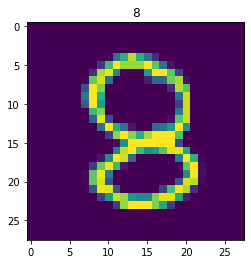

In [1]:
import numpy as np
import matplotlib.pyplot as plt

with np.load('prediction-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER
# 2. INDEX: COLOR CHANNEL
# 3/4. INDEX: PIXEL VALUE
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

# TEST DATA: INPUT (x) ONLY
print(test_x.shape, test_x.dtype)

plt.imshow(data_x[0, 0])
plt.title(data_y[0])
plt.show()

# Prediction

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from scipy.stats import describe
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import StratifiedShuffleSplit

## Hyperparameters

In [3]:
TEST_SIZE = 0.1
VAL_SIZE = 0.2
CROSS_VAL_K = 5
BATCH_SIZE = 50
EPOCHS = 5

## Train - Validation - Test - Split

90% (80% Train + 20% Validation) + 10% Test

In [4]:
X, X_test, y, y_test = train_test_split(data_x,data_y, test_size=TEST_SIZE,shuffle=True,random_state=22)

In [5]:
class MnistDataset(Dataset):
    def __init__(self, images, labels, transform=None, target_transform=None):
        self.labels = labels
        self.images = images
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = torch.tensor(self.labels[idx])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return (image,label)

In [6]:
dataset = MnistDataset(np.transpose(X,(0,2,3,1)),y,transform=transforms.Compose([
          transforms.ToTensor()
        , transforms.Normalize(X.mean(), X.std() )
    ]))

Neural network adapted from [this](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) pytorch tutorial.

In [7]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 4*4 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [9]:


val_method = StratifiedShuffleSplit(n_splits=CROSS_VAL_K, test_size=VAL_SIZE, random_state=91)

for train_indices, val_indices in val_method.split(X,y):
    train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
    val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=4)
    for epoch in range(EPOCHS):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

[1,   100] loss: 0.049
[1,   200] loss: 0.016
[2,   100] loss: 0.009
[2,   200] loss: 0.008
[3,   100] loss: 0.005
[3,   200] loss: 0.005
[4,   100] loss: 0.003
[4,   200] loss: 0.004
[5,   100] loss: 0.003
[5,   200] loss: 0.003
[1,   100] loss: 0.003
[1,   200] loss: 0.004
[2,   100] loss: 0.002
[2,   200] loss: 0.002
[3,   100] loss: 0.002
[3,   200] loss: 0.002
[4,   100] loss: 0.001
[4,   200] loss: 0.002
[5,   100] loss: 0.001
[5,   200] loss: 0.001
[1,   100] loss: 0.002
[1,   200] loss: 0.002
[2,   100] loss: 0.001
[2,   200] loss: 0.001
[3,   100] loss: 0.001
[3,   200] loss: 0.001
[4,   100] loss: 0.001
[4,   200] loss: 0.001
[5,   100] loss: 0.000
[5,   200] loss: 0.000
[1,   100] loss: 0.001
[1,   200] loss: 0.001
[2,   100] loss: 0.001
[2,   200] loss: 0.001
[3,   100] loss: 0.000
[3,   200] loss: 0.001
[4,   100] loss: 0.000
[4,   200] loss: 0.001
[5,   100] loss: 0.000
[5,   200] loss: 0.000
[1,   100] loss: 0.001
[1,   200] loss: 0.001
[2,   100] loss: 0.000
[2,   200] 

## Estimate network performance with test set

In [10]:
X_test_standardized = (X_test-X.mean())/X.std()
outputs=net(torch.from_numpy(X_test_standardized) )
_, predicted = torch.max(outputs, 1)

In [11]:
print(f"Performance on test set: {(np.equal(predicted,y_test).sum()/y_test.shape[0]).item()*100:.2f}% correct classified")

Performance on test set: 97.95% correct classified


## Final prediction

In [12]:
test_x_standardized = (test_x-X.mean())/X.std()

outputs=net(torch.from_numpy(test_x_standardized) )
_, prediction = torch.max(outputs, 1)

# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 2000

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction)

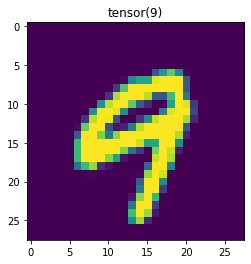

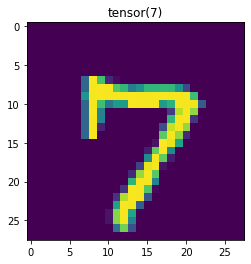

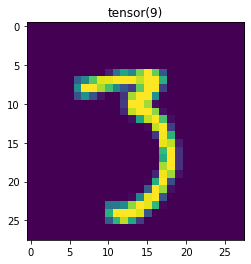

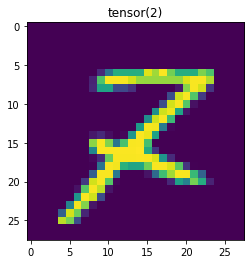

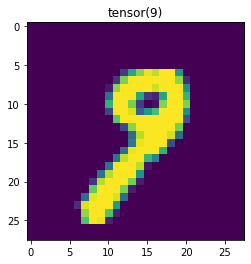

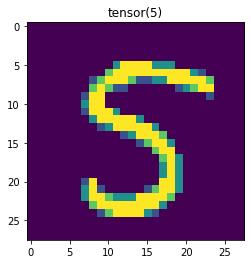

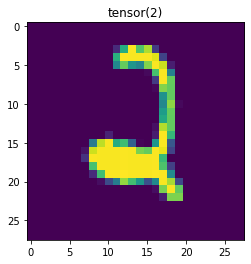

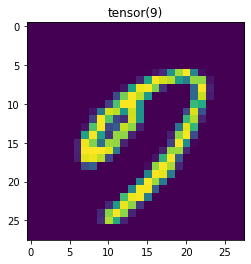

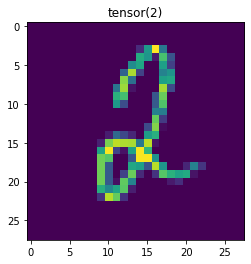

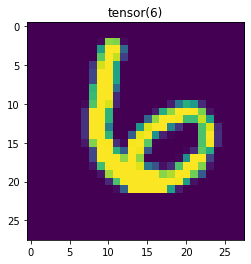

In [14]:
for img, p in list(zip(test_x, prediction))[:10]:
    plt.imshow(img[0])
    plt.title(p)
    plt.show()